In [1]:
from skimage import data, draw,color, data, restoration
from skimage import transform, util
from scipy import misc, fftpack, signal
import numpy as np
from skimage import filters, color
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import matplotlib.animation as animation
from scipy.misc import imresize
from scipy import ndimage as nd
import scipy
%matplotlib inline

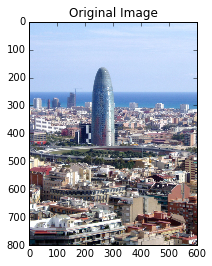

In [2]:
rgb =  plt.imread('agbar.png')
img = color.rgb2gray(rgb)
img = util.img_as_float(img)

plt.title('Original Image')
plt.imshow(rgb)

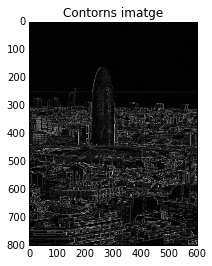

In [3]:
def gradient(img):
    '''
    compute image gradient magnitude matrix.
    '''
    gx, gy = np.gradient(img)
    grad = np.sqrt(gx*gx + gy*gy)
    return grad
grad = gradient(img)
plt.title('Contorns imatge')
plt.imshow(grad, cmap="gray" )

In [4]:
#normalitzacio d'imatge
def normalitzar(imatge):
    return np.real((imatge - np.min(imatge)) * 256 / (np.max(imatge) - np.min(imatge)))

In [5]:

#Calcul matriu d'energia que te cada zona
def energia(imatge):
    height,width = imatge.shape
    energia=np.zeros(imatge.shape)
    #asignem la primera linea igual que la imatge que tenim
    energia[0]=imatge[0]   
    for x in range(1,height):
        for y in range(0,width):
            if y == 0:
                min_val = min( energia[x-1, y], energia[x-1, y+1] )
            elif y < width - 2:
                min_val = min( energia[x-1, y], energia[x-1, y+1] )
                min_val = min( min_val, energia[x-1, y-1] )
            else:
                min_val = min( energia[x-1, y], energia[x-1, y-1] )
            energia[x,y] = imatge[x,y] + min_val
    return energia
            
    
    

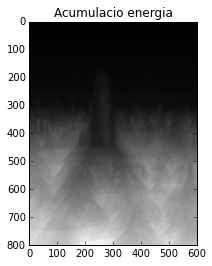

In [6]:
#grad=normalitzar(grad)
E = energia(grad)
plt.title('Acumulacio energia')
plt.imshow(E, cmap="gray" )


In [7]:
# El calcul del tall vertical hem de buscar el cami amb cost minim. BACKTRACKING
# Aquest tall pot ser vertical o horitzontal, es un camí de pixels connectats. En el nostre cas l'apliquem vertical
# La función de importancia / energía valora un píxel mediante la medición de su contraste con sus píxeles vecinos.
# Des de la imatge en escala de grisos retornarem el tall vertical mes baix com a llista de pixels

def tall_vertical(grad,cost):
    # Anem fins al -1 perque aixi es quedara en el 0, que tambe el necessitem.
    width, height = grad.shape
    
    min_val = 1e1000
    path = []
    for y in range(height):
        if cost[width-1,y] < min_val:
            min_val = cost[width-1,y]
            min_ptr = y
            
    pos = (width-1, min_ptr)
    path.append(pos) 
    while pos[0] != 0:
        val = cost[pos] - grad[pos]
        x,y = pos
        if y == 0:
            if val == cost[x-1,y+1]:
                pos = (x-1,y+1)
            else:
                pos = (x-1,y)
        elif y <= height - 2:
            if val == cost[x-1,y+1]:
                pos = (x-1,y+1)
            elif val == cost[x-1,y]:
                pos = (x-1,y)
            else:
                pos = (x-1,y-1)
        else:
            if val == cost[x-1,y]:
                pos = (x-1,y)
            else:
                pos = (x-1,y-1)
                
        path.append(pos)  
    return path 


In [8]:
class get_mouse_click():
    """Mouse interaction interface for radial distortion removal.

    """
    def __init__(self, img):
      height, width = img.shape[:2]
      self.figure = plt.imshow(img, extent=(0, width, height, 0))
      plt.gray()
      plt.title('select the object to remove')
      plt.xlabel('Select sets of  points with left mouse button,\n'
                 'click right button to close the polygon.')
      plt.connect('button_press_event', self.button_press)
      plt.connect('motion_notify_event', self.mouse_move)

      self.img = np.atleast_3d(img)
      self.points = []
      self.centre = np.array([(width - 1)/2., (height - 1)/2.])

      self.height = height
      self.width = width

      self.make_cursorline()
      self.figure.axes.set_autoscale_on(False)

      plt.show()
      plt.close()

    def make_cursorline(self):
        self.cursorline, = plt.plot([0],[0],'r:+',
                                    linewidth=2,markersize=15,markeredgecolor='b')

    def button_press(self,event):
        """Register mouse clicks.

        """
        if (event.button == 1 and event.xdata and event.ydata):
            self.points.append((event.xdata,event.ydata))
            print "Coordinate entered: (%f,%f)" % (event.xdata, event.ydata)

            #if len(self.points) % 2 == 0:
            plt.gca().lines.append(self.cursorline)
            self.make_cursorline()

        if (event.button != 1):
            #print "pepito: " ,self.points
            self.points.append((self.points[0][0],self.points[0][1]))
            plt.close()
            return self.points
            #qui
            #print "Removing distortion..."
            #plt.gca().lines = []
            #plt.draw()
            #self.remove_distortion()
            #self.points = []

    def mouse_move(self,event):
        """Handle cursor drawing.

        """
        #pt_sets, pts_last_set = divmod(len(self.points),5)
        #print pts_last_set
        pts_last_set=len(self.points)
        #print pts_last_set2
        pts = np.zeros((pts_last_set+1,2))
        if pts_last_set > 0:
            # Line follows up to 3 clicked points:
            pts[:pts_last_set] = self.points[-pts_last_set:]
            # The last point of the line follows the mouse cursor
        pts[pts_last_set:] = [event.xdata,event.ydata]
        #print pts
        self.cursorline.set_data(pts[:,0], pts[:,1])
        plt.draw()


def compute_mask(width,height,polygon):
    
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    mask = np.array(img)
    mask100 = 100*np.ones([mask.shape[0],mask.shape[1]])
    mask=mask*101
    mask = 1. - mask; # switch 0s and 1s
    return mask

In [9]:
def borrar_cami (img, path):
    height, width = img.shape[:2]
    img_retallada = np.zeros((height, width-1, img.shape[2]))
    path_cpy = set(path)
    visitat = set()
    #print path[1]
    for x in range(height):
        for y in range(width):
            if x not in visitat and (x,y) not in path_cpy:
                img_retallada[x,y] = img[x,y]
            elif (x,y) in path_cpy:
                visitat.add(x)
            else:
                img_retallada[x,y-1] = img[x,y]
    #print img_retallada.shape
    return img_retallada;

            


(800L, 500L, 3L)


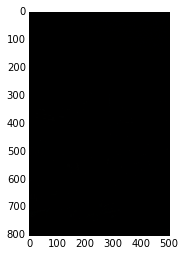

In [10]:

path = []
#path= tall_vertical(h, llistaBacktracking[2], E, path)    
#borrar_cami(grad, path)

for t in range(100): 
    path = []
    path = tall_vertical(grad,E)
    rgb = borrar_cami(rgb, path)

plt.imshow(rgb.astype('uint8'))
print rgb.shape
scipy.misc.imsave('Reduccion_final.jpg', rgb)

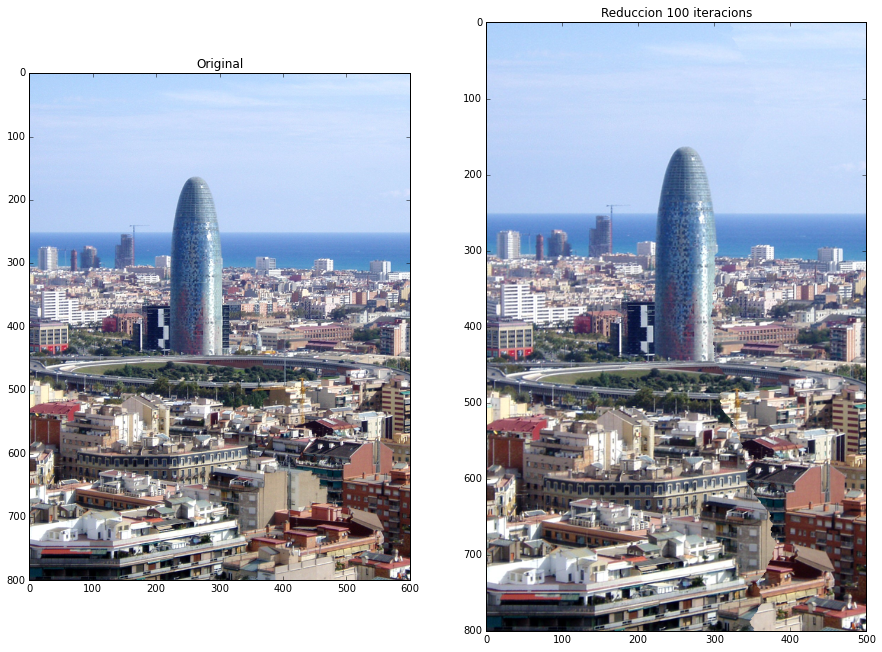

In [11]:
######################Comparacio RESULTATS
plt.subplot(1,2,1)
plt.imshow(plt.imread('agbar.png'))
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(rgb)
plt.title('Reduccion 100 iteracions')
plt.gcf().set_size_inches((15,15))

